Building a LR finder in this nb. To do that we create a testcallback's idea. The problem is that it wasn't working and to actually stop training you'd need to return False(meaning cancel) for every callback or add something that checks for self.stop in lots of places which would be a real pain and wouldn't be flexible enough. SO Jeremy suggest to use the idea of exceptions as a kind of control flow. Besides handling errors, Exceptions are a versatile way of writing vey neat code.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_05 import *

## EarlyStopping

### Better callback cancelation

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [11]:
#export 
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    # makes more sense to add this function below in the Callback class rather than the runner class.
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train:return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
    
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [22]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs= None):
            cbs = listify(cbs)
            for cbf in listify(cb_funcs):
                cb = cbf()
                setattr(self, cb.name, cb)
                cbs.append(cb)
            self.stop, self.cbs = False, [TrainEvalCallback()]+ cbs
                
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data
    
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            if self('begin_batch'): return
            self.pred = self.model(self.xb)
            if self('after_pred'): return
            self.loss = self.loss_func(self.pred, self.yb)
            if self('after_loss') or not self.in_train: return
            self.loss.backward()
            if self('after_backward'): return
            self.opt.step()
            if self('after_step'): return
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
        
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl:self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
                
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None
    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):res = cb(cb_name) or res
        #print(cb(cb_name), res)
        return res

In [18]:
learn = create_learner(get_model, loss_func, data)

In [19]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10:raise CancelTrainException()

In [23]:
run = Runner(cb_funcs=TestCallback)

In [24]:
run.fit(10, learn)

0
1
2
3
4
5
6
7
8
9
10


And now it workks yay!

### Other callbacks

In [65]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
    
class Recorder(Callback):
    def begin_fit(self):
        self.lrs=[[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs): lr.append([pg['lr']])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
    
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses)- skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

### LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [66]:
class lr_find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss=100
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss> self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [67]:
learn = create_learner(get_model, loss_func, data)

In [68]:
run = Runner(cb_funcs=[lr_find, Recorder])

In [69]:
run.fit(2, learn)

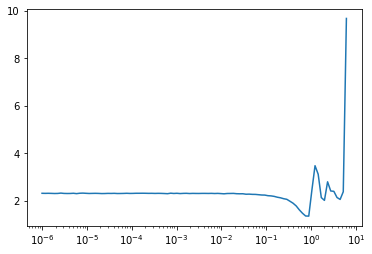

In [74]:
run.recorder.plot(skip_last=100)

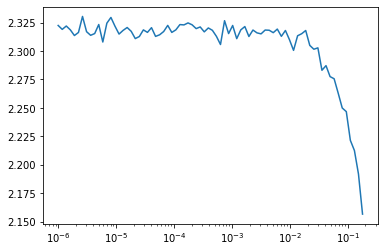

In [78]:
run.recorder.plot(skip_last=23)

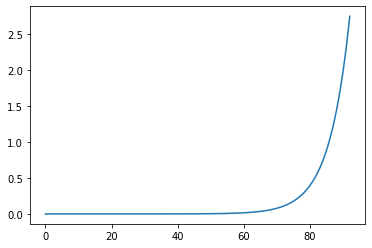

In [63]:
run.recorder.plot_lr()

## Export

In [75]:
!python notebook2script.py 05b_early_stopping.ipynb

Converted 05b_early_stopping.ipynb to exp\nb_05b.py
